# Play with geospatial data in xarray

In [1]:
!pip install -q planetary_computer

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-events 0.7.0 requires jsonschema[format-nongpl]>=4.18.0, but you have jsonschema 4.17.3 which is incompatible.
jupyterlab-server 2.25.0 requires jsonschema>=4.18.0, but you have jsonschema 4.17.3 which is incompatible.


In [2]:
import pystac_client
import planetary_computer
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import pandas as pd
import odc.stac
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rasterio as rio
import geopandas as gpd
import stackstac
import odc.stac

## Read in a geometry of an area of interest from a geojson file

In [3]:
aoi_gdf = gpd.read_file('map.geojson')

<Axes: >

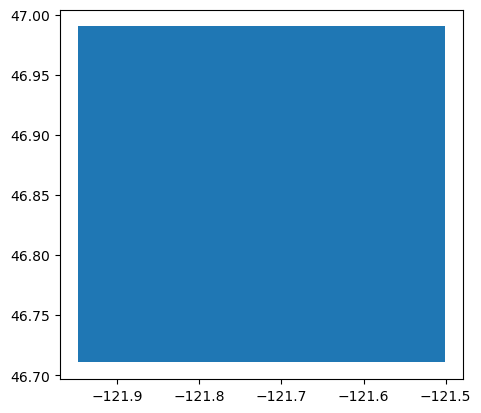

In [4]:
aoi_gdf.plot()

## Grab Copernicus 30M DEM from Microsoft Planetary Computer

In [5]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = catalog.search(collections=["cop-dem-glo-30"],bbox=aoi_gdf.total_bounds)
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 1 Items


## Use stackstac (or try odc.stac) to bring in the data as an xarray

In [6]:
dem_raster = stackstac.stack(items).squeeze()

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:364: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [7]:
dem_raster

<xarray.DataArray 'stackstac-de965066f419dc00141dc46df622f3a9' (y: 3601, x: 3601)>
dask.array<getitem, shape=(3601, 3601), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
    time            datetime64[ns] 2021-04-22
    id              <U40 'Copernicus_DSM_COG_10_N46_00_W122_00_DEM'
    band            <U4 'data'
  * x               (x) float64 -122.0 -122.0 -122.0 ... -121.0 -121.0 -121.0
  * y               (y) float64 47.0 47.0 47.0 47.0 47.0 ... 46.0 46.0 46.0 46.0
    proj:transform  object {0.0, -0.0002777777777777778, -122.00013888888888,...
    proj:epsg       int64 4326
    proj:shape      object {3600}
    platform        <U8 'TanDEM-X'
    gsd             int64 30
    title           <U14 'N46_00_W122_00'
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-122.00027777777778, 46.0, -12...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-122.00|\n| 0.00,-0.00, 47.00|\n| 0.00, 0.00, 1...
    resolution:  0.0002777777777777778

## Plot an xarray dataarray

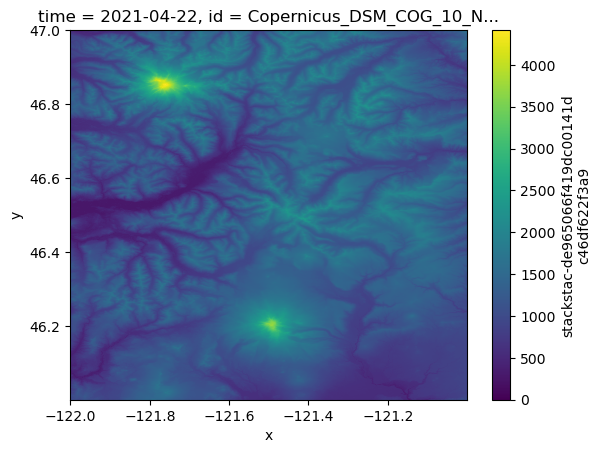

In [8]:
dem_raster.plot()

## let's clip to our area of interest

In [9]:
dem_raster_clipped = dem_raster.rio.clip(aoi_gdf.geometry)

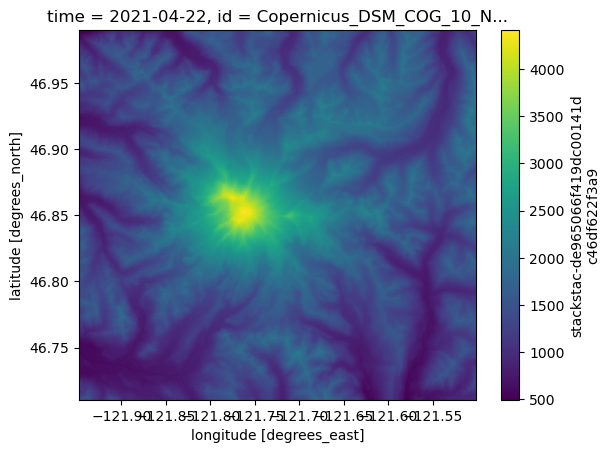

In [10]:
dem_raster_clipped.plot()

## Given a list of points, let's extract the values and make a tabular dataset

In [36]:
point_geoms = gpd.points_from_xy(x=[-121.9,-121.8,-121.7],y=[46.75,46.77,46.78])

In [60]:
points = gpd.GeoDataFrame(geometry=point_geoms,crs='EPSG:4326')
points['x'] = point_geoms.x
points['y'] = point_geoms.y
points['elevation'] = dem_raster_clipped.sel(x=xr.DataArray(point_geoms.x, dims="points"), y=xr.DataArray(point_geoms.y, dims="points"), method='nearest')

In [62]:
points

,geometry,x,y,elevation
0,POINT (-121.90000 46.75000),-121.9,46.75,863.016968
1,POINT (-121.80000 46.77000),-121.8,46.77,1188.408691
2,POINT (-121.70000 46.78000),-121.7,46.78,1376.398315


## Now let's plot these points

<Axes: title={'center': 'time = 2021-04-22, id = Copernicus_DSM_COG_10_N...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

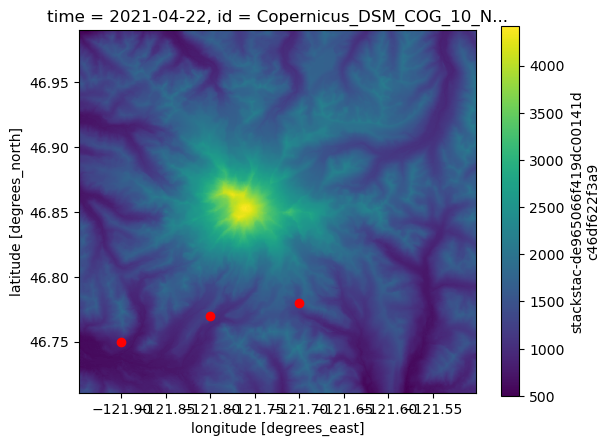

In [63]:
f,ax=plt.subplots()
dem_raster_clipped.plot(ax=ax)
points.plot(ax=ax,color='red')

## let's project to UTM zone 10N

In [64]:
dem_raster_clipped_projected = dem_raster_clipped.rio.reproject("EPSG:32610",nodata=np.nan)

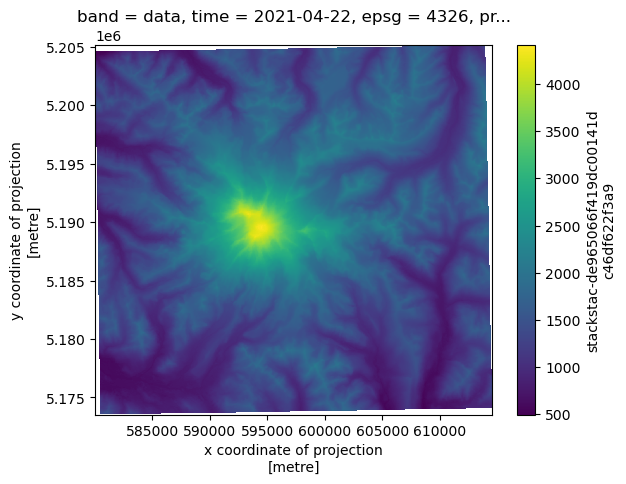

In [65]:
dem_raster_clipped_projected.plot()

## I want to reproject to the exact grid of another raster (match projection, grid, and resolution)